In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import scipy.cluster.hierarchy as shc
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
import statsmodels.api as sm
from sklearn.metrics import classification_report
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [2]:
def encode_column(df, column_name):
    # Inicializamos el LabelEncoder
    le = LabelEncoder()
    
    # Aplicamos el encoding en la columna y almacenamos las clases para futuros usos
    df[column_name] = le.fit_transform(df[column_name])
    
    # Retornamos el dataframe y el LabelEncoder para transformaciones futuras
    return df, le

In [3]:
def encode_top_n(df, column_name, top_n=10):
    # Obtiene los top_n valores más frecuentes
    top_values = df[column_name].value_counts().nlargest(top_n).index
    
    # Reemplaza los valores menos frecuentes por 'otros'
    df[column_name] = df[column_name].apply(lambda x: x if x in top_values else "otros")
    df[column_name] = df[column_name].astype(str)
    # Aplica el LabelEncoder
    return df

In [4]:
df = pd.read_pickle("../output/base_etapa_2.pkl")

In [5]:
df_process = df.copy()

In [6]:
df_process['requested_amount_cuartil'] = pd.qcut(df_process['requested_amount'], q=4, labels=[0, 1, 2, 3])
df_process['loan_term_cuartil'] = pd.qcut(df_process['loan_term'], q=3, labels=[0, 1, 2])
df_process['cibil_score_cuartil'] = pd.qcut(df_process['cibil_score'], q=3, labels=[0, 1, 2])
df_process['irr_cuartil'] = pd.qcut(df_process['irr'], q=4, labels=[0, 1, 2, 3])

In [7]:
cluster_columns = [ 'irr_log',  'product_4', 'product_1', 'product_19', 'product_20']
cluster_columns = [ 'irr_log',  'product_4', 'segment_8', 'product_20', 'segment_1', 'product_16', 'product_7']
cluster_columns = [ 'requested_amount_cuartil', 'loan_term_cuartil','cibil_score_cuartil', 'segment_le']

In [8]:
df_cluster = df_process[cluster_columns]

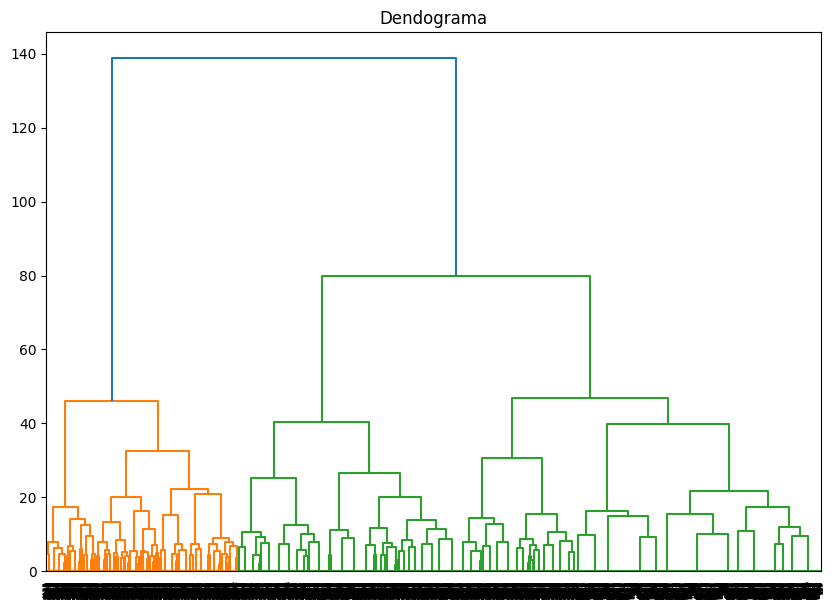

In [9]:
plt.figure(figsize=(10, 7))
plt.title("Dendograma")
dend = shc.dendrogram(shc.linkage(df_cluster.sample(5000), method='ward'))

In [10]:
cluster = AgglomerativeClustering(n_clusters= 5, metric='euclidean', linkage='ward')
df_cluster['cluster'] = cluster.fit_predict(df_cluster)

In [11]:
df_dummies = pd.get_dummies(df_cluster['cluster'], prefix='segmento')
# Convertimos los valores booleanos a enteros si es necesario
df_dummies = df_dummies.astype(int)

In [12]:
df_segmento = pd.merge(df_process, df_cluster[["cluster"]], left_index=True, right_index=True)
df_segmento = df_segmento.groupby(by=["cluster"]).agg({"irr": "mean", "disbursed":"sum", "cluster":"count"}).reset_index(drop=True)
df_segmento["porcentaje"] = df_segmento["disbursed"] / df_segmento["cluster"]

In [13]:
df_analisis = pd.merge(df_process, df_dummies, left_index=True, right_index=True)

In [14]:
df_analisis.groupby(by=["irr_cuartil"]).agg({'cibil_score':'median'})

,cibil_score
irr_cuartil,
0,771.0
1,763.0
2,752.0
3,754.0


In [15]:
df_analisis["requested_amount"]

0        300000
1        250000
9        292000
10       437500
16       450000
          ...  
17759    272000
17760    350000
17761    512000
17762    100000
17763    500000
Name: requested_amount, Length: 12055, dtype: int64

In [16]:
df_analisis.groupby(by=["irr_cuartil"]).agg({'requested_amount':'median'})

,requested_amount
irr_cuartil,
0,425000.0
1,375000.0
2,380000.0
3,400000.0


In [17]:
df_analisis['ln_irr_seg_1'] = (df_analisis['irr_log']*df_analisis['segmento_1'])
df_analisis['ln_irr_seg_2'] = (df_analisis['irr_log']*df_analisis['segmento_2'])
df_analisis['ln_irr_seg_3'] = (df_analisis['irr_log']*df_analisis['segmento_3'])
df_analisis['ln_irr_seg_4'] = (df_analisis['irr_log']*df_analisis['segmento_4'])

In [18]:
df_analisis = df_analisis.reset_index(drop=True)

In [19]:
def fit_logit_model(df, variables_x, variables_y):
    Y = df[variables_y]
    X = df[variables_x]
    X = sm.add_constant(X, prepend=False)

    model_logit = sm.Logit(endog=Y, exog=X).fit()
    print(model_logit.summary())

    Y_pred = model_logit.predict(X).round(0).astype(int)
    # Reporte de métricas
    reporte = classification_report(Y, Y_pred, labels=[1, 0])
    print("Reporte de clasificación:\n", reporte)
    return model_logit

In [20]:
variables_x = ['irr_log', 
               'segmento_1', 'segmento_2', 'segmento_3', 'segmento_4', 
               'ln_irr_seg_1', 'ln_irr_seg_2', 'ln_irr_seg_3', 'ln_irr_seg_4',
              ]
variables_y = 'disbursed'

In [21]:
modelo = fit_logit_model(df_analisis, variables_x, variables_y)

Optimization terminated successfully.
         Current function value: 0.428478
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:              disbursed   No. Observations:                12055
Model:                          Logit   Df Residuals:                    12045
Method:                           MLE   Df Model:                            9
Date:                Sun, 03 Nov 2024   Pseudo R-squ.:                  0.3771
Time:                        13:48:13   Log-Likelihood:                -5165.3
converged:                       True   LL-Null:                       -8292.9
Covariance Type:            nonrobust   LLR p-value:                     0.000
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
irr_log        -17.6247      0.640    -27.560      0.000     -18.878     -16.371
segmento_1      -5.4043

In [22]:
df_analisis['const'] = 1.0
df_analisis['prob_T1'] = modelo.predict(df_analisis[variables_x + ["const"]])

In [23]:
df_analisis['prob_T1'].describe()

count    12055.000000
mean         0.448942
std          0.328122
min          0.001994
25%          0.064633
50%          0.537813
75%          0.763512
max          0.904876
Name: prob_T1, dtype: float64

In [24]:
df_analisis['irr'].describe()

count    12055.000000
mean        19.843160
std          2.956696
min         16.500000
25%         17.400000
50%         18.600000
75%         22.200000
max         26.500000
Name: irr, dtype: float64

In [25]:
# Establecemos el rango de precios
rango_precios = np.linspace(16, 20, 20).round(4)

# Creamos el dataframe
df_elasticidad = pd.DataFrame(rango_precios)
df_elasticidad = df_elasticidad.rename({0: 'irr'}, axis=1)

In [26]:
# Preparamos los inputs para la predicción de demanda del segmento 0
X_data_seg0 = np.column_stack((np.log(df_elasticidad['irr']),
                          np.repeat(0, len(df_elasticidad['irr'])), # Coeficiente del segmento 1  ## variable dummy
                          np.repeat(0, len(df_elasticidad['irr'])), # Coeficiente del segmento 2
                          np.repeat(0, len(df_elasticidad['irr'])), # Coeficiente del segmento 3
                          np.repeat(0, len(df_elasticidad['irr'])), # Coeficiente del segmento 4
                          np.repeat(0, len(df_elasticidad['irr'])), # Interacción del precio y el segmento 1  ##Interacción con el precio
                          np.repeat(0, len(df_elasticidad['irr'])), # Interacción del precio y el segmento 2
                          np.repeat(0, len(df_elasticidad['irr'])), # Interacción del precio y el segmento 3
                          np.repeat(0, len(df_elasticidad['irr']))
                          )) # Interacción del precio y el segmento 4

In [27]:
# Preparamos los inputs para la predicción de demanda del segmento 1
X_data_seg1 = np.column_stack((np.log(df_elasticidad['irr']),
                          np.repeat(1, len(df_elasticidad['irr'])), # Coeficiente del segmento 1
                          np.repeat(0, len(df_elasticidad['irr'])), # Coeficiente del segmento 2
                          np.repeat(0, len(df_elasticidad['irr'])), # Coeficiente del segmento 3
                          np.repeat(0, len(df_elasticidad['irr'])), # Coeficiente del segmento 4
                          np.log(df_elasticidad['irr']), # Interacción del precio y el segmento 1
                          np.repeat(0, len(df_elasticidad['irr'])), # Interacción del precio y el segmento 2
                          np.repeat(0, len(df_elasticidad['irr'])), # Interacción del precio y el segmento 3
                          np.repeat(0, len(df_elasticidad['irr']))
                          )) # Interacción del precio y el segmento 4

In [28]:
# Preparamos los inputs para la predicción de demanda del segmento 2
X_data_seg2 = np.column_stack((np.log(df_elasticidad['irr']),
                          np.repeat(0, len(df_elasticidad['irr'])), # Coeficiente del segmento 1
                          np.repeat(1, len(df_elasticidad['irr'])), # Coeficiente del segmento 2
                          np.repeat(0, len(df_elasticidad['irr'])), # Coeficiente del segmento 3
                          np.repeat(0, len(df_elasticidad['irr'])), # Coeficiente del segmento 4
                          np.repeat(0, len(df_elasticidad['irr'])), # Interacción del precio y el segmento 1
                          np.log(df_elasticidad['irr']), # Interacción del precio y el segmento 2
                          np.repeat(0, len(df_elasticidad['irr'])), # Interacción del precio y el segmento 3
                          np.repeat(0, len(df_elasticidad['irr']))
                          )) # Interacción del precio y el segmento 4

In [29]:
# Preparamos los inputs para la predicción de demanda del segmento 3
X_data_seg3 = np.column_stack((np.log(df_elasticidad['irr']),
                          np.repeat(0, len(df_elasticidad['irr'])), # Coeficiente del segmento 1
                          np.repeat(0, len(df_elasticidad['irr'])), # Coeficiente del segmento 2
                          np.repeat(1, len(df_elasticidad['irr'])), # Coeficiente del segmento 3
                          np.repeat(0, len(df_elasticidad['irr'])), # Coeficiente del segmento 4
                          np.repeat(0, len(df_elasticidad['irr'])), # Interacción del precio y el segmento 1
                          np.repeat(0, len(df_elasticidad['irr'])), # Interacción del precio y el segmento 2
                          np.log(df_elasticidad['irr']), # Interacción del precio y el segmento 3
                          np.repeat(0, len(df_elasticidad['irr']))
                          )) # Interacción del precio y el segmento 4

In [30]:
# Preparamos los inputs para la predicción de demanda del segmento 4
X_data_seg4 = np.column_stack((np.log(df_elasticidad['irr']),
                          np.repeat(0, len(df_elasticidad['irr'])), # Coeficiente del segmento 1
                          np.repeat(0, len(df_elasticidad['irr'])), # Coeficiente del segmento 2
                          np.repeat(0, len(df_elasticidad['irr'])), # Coeficiente del segmento 3
                          np.repeat(1, len(df_elasticidad['irr'])), # Coeficiente del segmento 4
                          np.repeat(0, len(df_elasticidad['irr'])), # Interacción del precio y el segmento 1
                          np.repeat(0, len(df_elasticidad['irr'])), # Interacción del precio y el segmento 2
                          np.repeat(0, len(df_elasticidad['irr'])), # Interacción del precio y el segmento 3
                          np.log(df_elasticidad['irr']))) # Interacción del precio y el segmento 4

In [31]:
# Agregamos la constante del coeficiente de intercepción
X_data_seg0 = sm.add_constant(X_data_seg0, prepend=False, has_constant='add')
X_data_seg1 = sm.add_constant(X_data_seg1, prepend=False, has_constant='add')
X_data_seg2 = sm.add_constant(X_data_seg2, prepend=False, has_constant='add')
X_data_seg3 = sm.add_constant(X_data_seg3, prepend=False, has_constant='add')
X_data_seg4 = sm.add_constant(X_data_seg4, prepend=False, has_constant='add')

In [32]:
# Predecimos las nuevas cantidades demandadas (previa conversión de logaritmo natural)
df_elasticidad['prob_seg0'] = modelo.predict(X_data_seg0)
df_elasticidad['prob_seg1'] = modelo.predict(X_data_seg1)
df_elasticidad['prob_seg2'] = modelo.predict(X_data_seg2)
df_elasticidad['prob_seg3'] = modelo.predict(X_data_seg3)
df_elasticidad['prob_seg4'] = modelo.predict(X_data_seg4)
df_elasticidad.head()

,irr,prob_seg0,prob_seg1,prob_seg2,prob_seg3,prob_seg4
0,16.0000,0.935652,0.939023,0.908777,0.914462,0.886694
1,16.2105,0.920310,0.926200,0.891861,0.896278,0.867423
2,16.4211,0.901949,0.911142,0.872511,0.875048,0.845737
3,16.6316,0.880227,0.893619,0.850593,0.850551,0.821578
4,16.8421,0.854819,0.873400,0.825993,0.822608,0.794912


In [33]:
df_analisis["requested_amount"].describe()

count    1.205500e+04
mean     5.020410e+05
std      4.544493e+05
min      7.200000e+01
25%      2.599750e+05
50%      4.000000e+05
75%      6.000000e+05
max      2.184000e+07
Name: requested_amount, dtype: float64

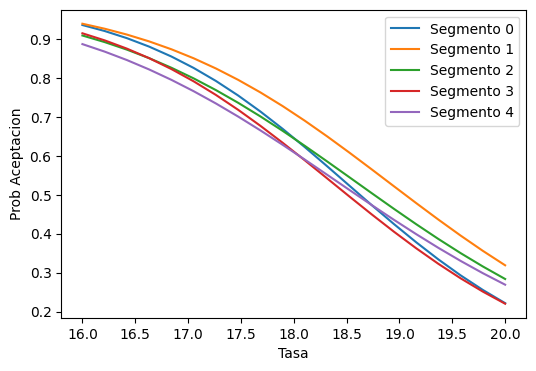

In [34]:
# Crear la figura
plt.figure(figsize=(6, 4))

# Graficar cada línea con `plot`
plt.plot(df_elasticidad["irr"], df_elasticidad["prob_seg0"], label='Segmento 0')
plt.plot(df_elasticidad["irr"], df_elasticidad["prob_seg1"], label='Segmento 1')
plt.plot(df_elasticidad["irr"], df_elasticidad["prob_seg2"], label='Segmento 2')
plt.plot(df_elasticidad["irr"], df_elasticidad["prob_seg3"], label='Segmento 3')
plt.plot(df_elasticidad["irr"], df_elasticidad["prob_seg4"], label='Segmento 4')

# Añadir etiquetas y leyenda
plt.xlabel('Tasa')
plt.ylabel('Prob Aceptacion')
plt.legend()

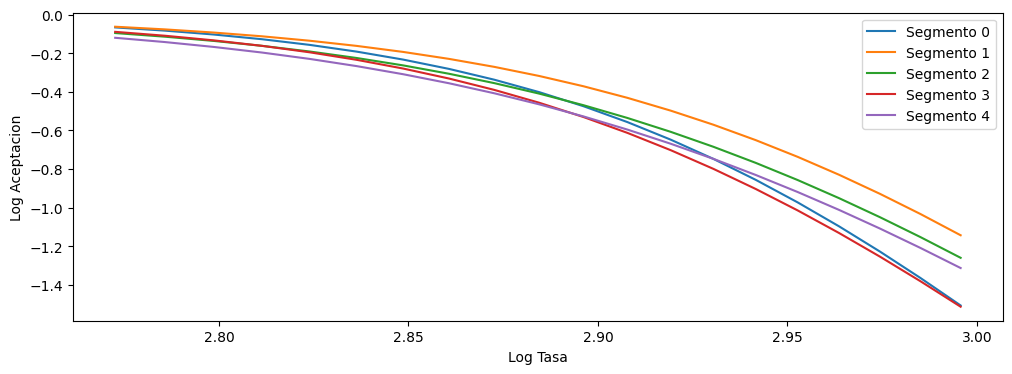

In [35]:
# Crear la figura
plt.figure(figsize=(12, 4))

# Graficar cada línea con `plot`
plt.plot(np.log(df_elasticidad["irr"]), np.log(df_elasticidad["prob_seg0"]), label='Segmento 0')
plt.plot(np.log(df_elasticidad["irr"]), np.log(df_elasticidad["prob_seg1"]), label='Segmento 1')
plt.plot(np.log(df_elasticidad["irr"]), np.log(df_elasticidad["prob_seg2"]), label='Segmento 2')
plt.plot(np.log(df_elasticidad["irr"]), np.log(df_elasticidad["prob_seg3"]), label='Segmento 3')
plt.plot(np.log(df_elasticidad["irr"]), np.log(df_elasticidad["prob_seg4"]), label='Segmento 4')

# Añadir etiquetas y leyenda
plt.xlabel('Log Tasa')
plt.ylabel('Log Aceptacion')
plt.legend()

In [36]:
# Creamos una lista para almacenar el monto promedio para cada intervalo de irr
monto_avg = []

# Iteramos sobre cada fila de df_elasticidad excepto la última
for i in range(len(df_elasticidad) - 1):
    irr_min = df_elasticidad.loc[i, 'irr']
    irr_max = df_elasticidad.loc[i + 1, 'irr']
    
    # Filtramos los montos en df_analisis que están en el rango entre irr_min y irr_max
    monto_rango = df_analisis[(df_analisis['irr'] >= irr_min) & (df_analisis['irr'] < irr_max) & (df_analisis["disbursed"]==1)]['requested_amount']
    
    # Calculamos el promedio de los montos en este rango
    monto_avg.append(monto_rango.median())

# Para el último rango, tomamos todos los valores de irr que sean mayores al último irr en df_elasticidad
irr_min = df_elasticidad['irr'].iloc[-1]
monto_rango = df_analisis[(df_analisis['irr'] >= irr_min) & (df_analisis["disbursed"]==1)]['requested_amount']
monto_avg.append(monto_rango.median())

df_elasticidad["requested_amount"] = monto_avg

In [37]:
# Creamos una lista para almacenar el monto promedio para cada intervalo de irr
monto_avg = []

# Iteramos sobre cada fila de df_elasticidad excepto la última
for i in range(len(df_elasticidad) - 1):
    irr_min = df_elasticidad.loc[i, 'irr']
    irr_max = df_elasticidad.loc[i + 1, 'irr']
    
    # Filtramos los montos en df_analisis que están en el rango entre irr_min y irr_max
    monto_rango = df_analisis[(df_analisis['irr'] >= irr_min) & (df_analisis['irr'] < irr_max) & (df_analisis["disbursed"]==1)]['emi_amount']
    
    # Calculamos el promedio de los montos en este rango
    monto_avg.append(monto_rango.median())

# Para el último rango, tomamos todos los valores de irr que sean mayores al último irr en df_elasticidad
irr_min = df_elasticidad['irr'].iloc[-1]
monto_rango = df_analisis[(df_analisis['irr'] >= irr_min) & (df_analisis["disbursed"]==1)]['emi_amount']
monto_avg.append(monto_rango.median())

df_elasticidad["emi_amount"] = monto_avg

In [38]:
# Creamos una lista para almacenar el monto promedio para cada intervalo de irr
monto_avg = []

# Iteramos sobre cada fila de df_elasticidad excepto la última
for i in range(len(df_elasticidad) - 1):
    irr_min = df_elasticidad.loc[i, 'irr']
    irr_max = df_elasticidad.loc[i + 1, 'irr']
    
    # Filtramos los montos en df_analisis que están en el rango entre irr_min y irr_max
    monto_rango = df_analisis[(df_analisis['irr'] >= irr_min) & (df_analisis['irr'] < irr_max) & (df_analisis["disbursed"]==1)]['cibil_score']
    
    # Calculamos el promedio de los montos en este rango
    monto_avg.append(monto_rango.median())

# Para el último rango, tomamos todos los valores de irr que sean mayores al último irr en df_elasticidad
irr_min = df_elasticidad['irr'].iloc[-1]
monto_rango = df_analisis[(df_analisis['irr'] >= irr_min) & (df_analisis["disbursed"]==1)]['cibil_score']
monto_avg.append(monto_rango.median())
df_elasticidad["cibil_score"] = monto_avg

In [39]:
# Creamos una lista para almacenar el monto promedio para cada intervalo de irr
monto_avg = []

# Iteramos sobre cada fila de df_elasticidad excepto la última
for i in range(len(df_elasticidad) - 1):
    irr_min = df_elasticidad.loc[i, 'irr']
    irr_max = df_elasticidad.loc[i + 1, 'irr']
    
    # Filtramos los montos en df_analisis que están en el rango entre irr_min y irr_max
    monto_rango = df_analisis[(df_analisis['irr'] >= irr_min) & (df_analisis['irr'] < irr_max) & (df_analisis["disbursed"]==1)]['loan_term']
    
    # Calculamos el promedio de los montos en este rango
    monto_avg.append(monto_rango.median())

# Para el último rango, tomamos todos los valores de irr que sean mayores al último irr en df_elasticidad
irr_min = df_elasticidad['irr'].iloc[-1]
monto_rango = df_analisis[(df_analisis['irr'] >= irr_min) & (df_analisis["disbursed"]==1)]['loan_term']
monto_avg.append(monto_rango.median())
df_elasticidad["loan_term"] = monto_avg

In [40]:
# Creamos una lista para almacenar el monto promedio para cada intervalo de irr
monto_avg = []

# Iteramos sobre cada fila de df_elasticidad excepto la última
for i in range(len(df_elasticidad) - 1):
    irr_min = df_elasticidad.loc[i, 'irr']
    irr_max = df_elasticidad.loc[i + 1, 'irr']
    
    # Filtramos los montos en df_analisis que están en el rango entre irr_min y irr_max
    monto_rango = df_analisis[(df_analisis['irr'] >= irr_min) & (df_analisis['irr'] < irr_max) & (df_analisis["disbursed"]==1)].shape[0]
    
    # Calculamos el promedio de los montos en este rango
    monto_avg.append(monto_rango)

# Para el último rango, tomamos todos los valores de irr que sean mayores al último irr en df_elasticidad
irr_min = df_elasticidad['irr'].iloc[-1]
monto_rango = df_analisis[(df_analisis['irr'] >= irr_min) & (df_analisis["disbursed"]==1)].shape[0]
monto_avg.append(monto_rango)
df_elasticidad["cantidad"] = monto_avg

In [41]:
# df_elasticidad['irr_mensual'] = df_elasticidad['irr'] / 12
# df_elasticidad['PR_mensual'] = df_elasticidad['irr_mensual'] / 5
# df_elasticidad["LGD"] = 0.15
# # Primera parte de la fórmula (cuota mensual de APR)
# df_elasticidad['parte_apr'] = df_elasticidad['irr_mensual'] / (1 - (1 + df_elasticidad['irr_mensual']) ** (-df_elasticidad['loan_term']))

# # Segunda parte de la fórmula (cuota mensual de PR_i)
# df_elasticidad['parte_pr'] = df_elasticidad['PR_mensual'] / (1 - (1 + df_elasticidad['PR_mensual']) ** (-df_elasticidad['loan_term']))

# # Fórmula completa
# df_elasticidad['resultado_seg0'] = (df_elasticidad['prob_seg1'] * df_elasticidad['requested_amount'] * df_elasticidad['loan_term'] *
#                    (df_elasticidad['parte_apr'] - df_elasticidad['parte_pr']) -
#                    (1 - df_elasticidad['prob_seg1']) * df_elasticidad['LGD'] * df_elasticidad['requested_amount'])

In [42]:
df_analisis["requested_amount"].describe()

count    1.205500e+04
mean     5.020410e+05
std      4.544493e+05
min      7.200000e+01
25%      2.599750e+05
50%      4.000000e+05
75%      6.000000e+05
max      2.184000e+07
Name: requested_amount, dtype: float64

In [43]:
rango_montos = np.linspace(25000, 60000, 20).round(2)


In [44]:
df_elasticidad["requested_amount_g"] = rango_montos

In [45]:
df_elasticidad.head()

,irr,prob_seg0,prob_seg1,prob_seg2,prob_seg3,prob_seg4,requested_amount,emi_amount,cibil_score,loan_term,cantidad,requested_amount_g
0,16.0000,0.935652,0.939023,0.908777,0.914462,0.886694,NaN,NaN,NaN,NaN,0,25000.00
1,16.2105,0.920310,0.926200,0.891861,0.896278,0.867423,NaN,NaN,NaN,NaN,0,26842.11
2,16.4211,0.901949,0.911142,0.872511,0.875048,0.845737,480000.0,13739.0,773.0,48.0,266,28684.21
3,16.6316,0.880227,0.893619,0.850593,0.850551,0.821578,450000.0,13611.0,778.0,48.0,515,30526.32
4,16.8421,0.854819,0.873400,0.825993,0.822608,0.794912,446500.0,13528.0,774.0,48.0,594,32368.42


In [49]:
df_elasticidad["requested_amount"] = df_elasticidad["requested_amount"].fillna(df_elasticidad["requested_amount"].min())
df_elasticidad["emi_amount"] = df_elasticidad["emi_amount"].fillna(df_elasticidad["emi_amount"].min())
df_elasticidad["cibil_score"] = df_elasticidad["cibil_score"].fillna(df_elasticidad["cibil_score"].min())
df_elasticidad["loan_term"] = df_elasticidad["loan_term"].fillna(df_elasticidad["loan_term"].min())

In [50]:
df_elasticidad["coef_seg0"] = modelo.params["irr_log"]
df_elasticidad["coef_seg1"] = modelo.params["ln_irr_seg_1"]
df_elasticidad["coef_seg2"] = modelo.params["ln_irr_seg_2"]
df_elasticidad["coef_seg3"] = modelo.params["ln_irr_seg_3"]
df_elasticidad["coef_seg4"] = modelo.params["ln_irr_seg_4"]

df_elasticidad["elasticidad_seg0"] = df_elasticidad["coef_seg0"]*np.log(df_elasticidad["irr"])*(1-df_elasticidad["prob_seg0"])
df_elasticidad["elasticidad_seg1"] = (df_elasticidad["coef_seg0"]+df_elasticidad["coef_seg1"])*np.log(df_elasticidad["irr"])*(1-df_elasticidad["prob_seg1"])
df_elasticidad["elasticidad_seg2"] = (df_elasticidad["coef_seg0"]+df_elasticidad["coef_seg2"])*np.log(df_elasticidad["irr"])*(1-df_elasticidad["prob_seg2"])
df_elasticidad["elasticidad_seg3"] = (df_elasticidad["coef_seg0"]+df_elasticidad["coef_seg3"])*np.log(df_elasticidad["irr"])*(1-df_elasticidad["prob_seg3"])
df_elasticidad["elasticidad_seg4"] = (df_elasticidad["coef_seg0"]+df_elasticidad["coef_seg4"])*np.log(df_elasticidad["irr"])*(1-df_elasticidad["prob_seg4"])

print(df_elasticidad["elasticidad_seg0"].mean())
print(df_elasticidad["elasticidad_seg1"].mean())
print(df_elasticidad["elasticidad_seg2"].mean())
print(df_elasticidad["elasticidad_seg3"].mean())
print(df_elasticidad["elasticidad_seg4"].mean())

-19.754666641260823
-14.851389646424323
-15.842401087349023
-19.39572947341437
-16.138423399707158


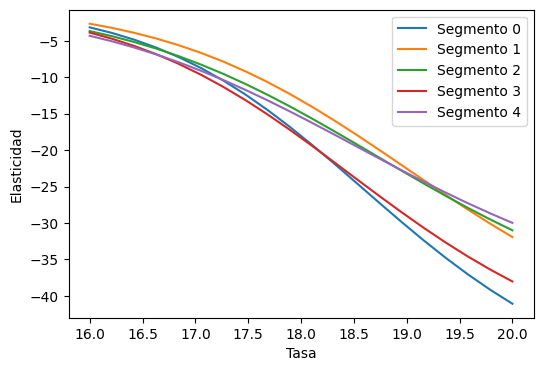

In [51]:
# Crear la figura
plt.figure(figsize=(6, 4))

# Graficar cada línea con `plot`
plt.plot(df_elasticidad["irr"], df_elasticidad["elasticidad_seg0"], label='Segmento 0')
plt.plot(df_elasticidad["irr"], df_elasticidad["elasticidad_seg1"], label='Segmento 1')
plt.plot(df_elasticidad["irr"], df_elasticidad["elasticidad_seg2"], label='Segmento 2')
plt.plot(df_elasticidad["irr"], df_elasticidad["elasticidad_seg3"], label='Segmento 3')
plt.plot(df_elasticidad["irr"], df_elasticidad["elasticidad_seg4"], label='Segmento 4')

# Añadir etiquetas y leyenda
plt.xlabel('Tasa')
plt.ylabel('Elasticidad')
plt.legend()

In [52]:
df_elasticidad.to_pickle("../output/base_etapa_3.pkl")